## Decision Support System (DSS) Span Analysis ##

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want to make the DDS Prototype ~/analysis/ directory to the Juypter container. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_

Navigate to the container UI and enter the token:
http://localhost:10000

In [1]:
install.packages("stringr")                # Install stringr package in R
library("stringr")                         # Load stringr package

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
setwd('/home/jovyan/work/data')

In [3]:
options(warn=-1)
spanData <- read.csv('span-data-2022-03-16 16_11_32.csv', header = TRUE)
attach(spanData)

# Exploratory Data Analysis #

In [4]:
head(spanData)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<chr>,<chr>
1,8cad21e3c9463b9197a8a3e3af9f3349,dss-prototype: /tracks,2022-03-16 16:06:37.551,17.2 ms
2,037f03ac8b8effd1489bdfe53461f024,dss-prototype: /tracks,2022-03-16 16:06:36.520,13.0 ms
3,61ab61c99e94eb78540bdc02fa8a2f8a,dss-prototype: /tracks,2022-03-16 16:06:35.483,14.8 ms
4,784677075f369d02cf4cfcec0c9a2153,dss-prototype: /tracks,2022-03-16 16:06:34.449,15.8 ms
5,e6a1a857d1d593e4acdce1a614b6e6a4,dss-prototype: /tracks,2022-03-16 16:06:31.419,15.0 ms
6,4ac28f1066cdda52dee5c63ca2db8024,dss-prototype: /tracks,2022-03-16 16:06:30.385,12.5 ms


In [5]:
summary(spanData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:24          Length:24          Length:24          Length:24         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [6]:
# Convert character data into numeric metrics

spanMetrics <- spanData

for(i in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[i,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-2),len)
    duration = as.numeric(duration)

    if(units == ' ms') {
        duration = duration / 1000              # Convert to ms
    } else if (units == ' µs') {
        duration = duration / 1000000           # Convert to µs
    } else {
        print ('Unable to find specified units')
    }
    spanMetrics[i,4] = duration
    
    # Convert time

    time = spanMetrics[i,3]
    epoch <- as.POSIXct(time)
    epoch_int <- as.integer(epoch)
    spanMetrics[i,3] = epoch_int
}

# Convert columns for char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

head(spanMetrics)
tail(spanMetrics)
summary(spanMetrics)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
1,8cad21e3c9463b9197a8a3e3af9f3349,dss-prototype: /tracks,1647446797,0.0172
2,037f03ac8b8effd1489bdfe53461f024,dss-prototype: /tracks,1647446796,0.0130
3,61ab61c99e94eb78540bdc02fa8a2f8a,dss-prototype: /tracks,1647446795,0.0148
4,784677075f369d02cf4cfcec0c9a2153,dss-prototype: /tracks,1647446794,0.0158
5,e6a1a857d1d593e4acdce1a614b6e6a4,dss-prototype: /tracks,1647446791,0.0150
6,4ac28f1066cdda52dee5c63ca2db8024,dss-prototype: /tracks,1647446790,0.0125


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
19,c6677a87f2c33ab508912362de58e10c,dss-prototype: /tracks,1647446772,0.0160
20,47741fe5cdfcec0b70002687f4e1a442,dss-prototype: /tracks,1647446769,0.0215
21,d838c1192aab42ee912f7c3bbfd32503,dss-prototype: /tracks,1647446768,0.0142
22,00cde24cb4be7ea296d24ee7b297284a,dss-prototype: /tracks,1647446767,0.0140
23,797507a4682d906a8cd62dccb00e1fcf,dss-prototype: /tracks,1647446766,0.0131
24,6fbf94e9e2cff83f62e3a082bf5de401,dss-prototype: /tracks,1647446765,0.0122


   Trace.ID          Trace.name          Start.time           Duration      
 Length:24          Length:24          Min.   :1.647e+09   Min.   :0.01200  
 Class :character   Class :character   1st Qu.:1.647e+09   1st Qu.:0.01307  
 Mode  :character   Mode  :character   Median :1.647e+09   Median :0.01395  
                                       Mean   :1.647e+09   Mean   :0.01560  
                                       3rd Qu.:1.647e+09   3rd Qu.:0.01603  
                                       Max.   :1.647e+09   Max.   :0.03220  

## Search for outliers

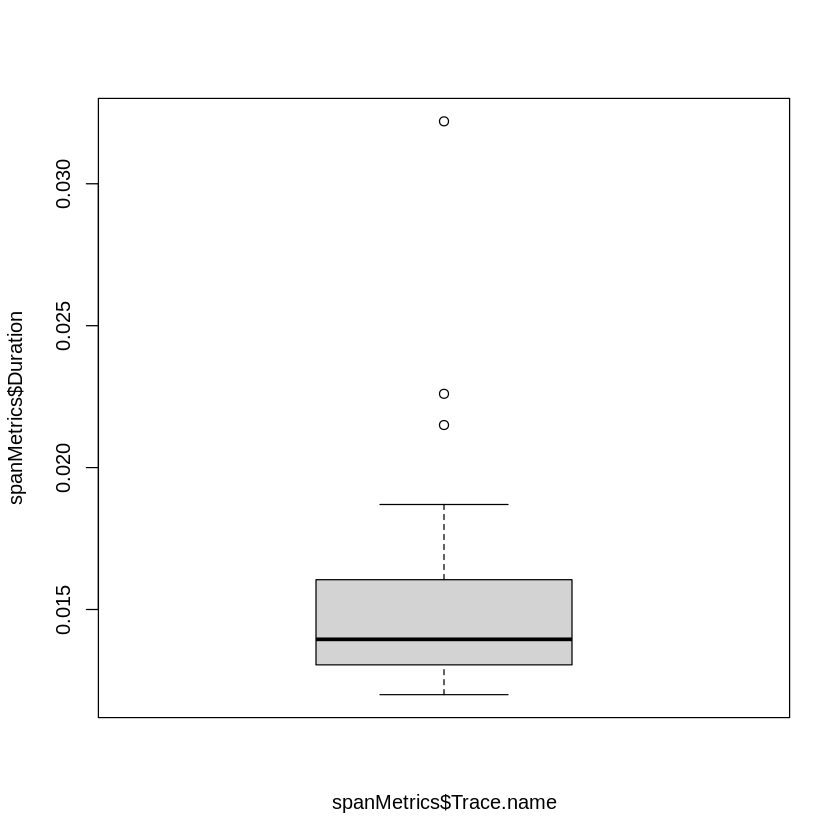

In [7]:
boxplot(spanMetrics$Duration~spanMetrics$Trace.name)

In [16]:
## Use this to get the values of the statistical outliers in trk_update_data from R
outliers <- boxplot(spanMetrics$Duration, plot = FALSE)$out
outliers
# spanMetrics$Duration[which(spanMetrics$Duration %in% outliers),]

[1] 0.0226 0.0322 0.0215

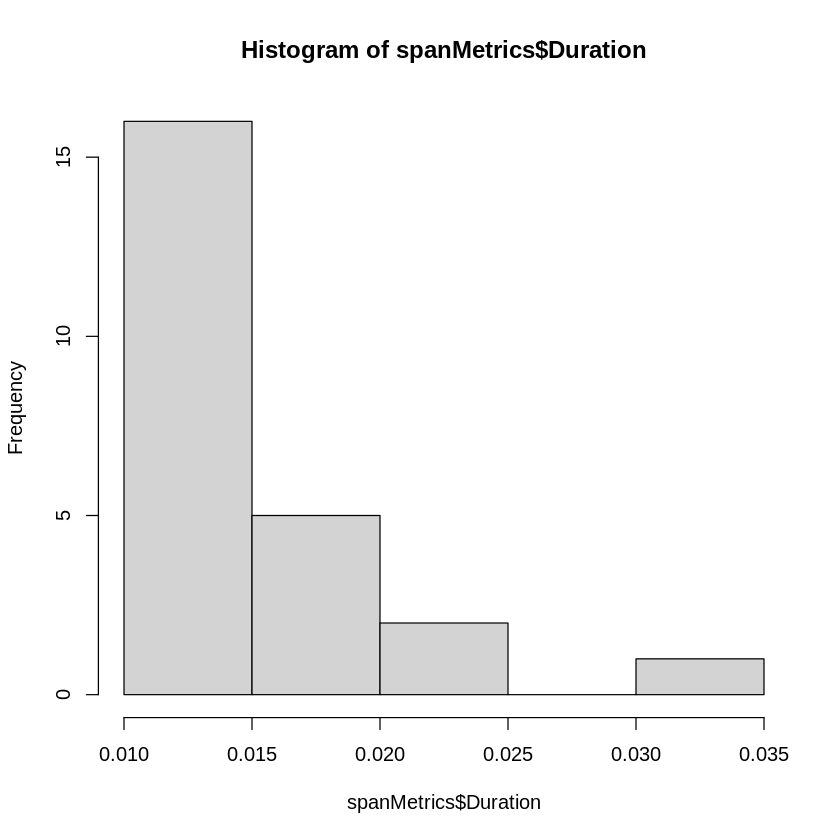

In [9]:
# par(mfrow=c(2,2))

hist(spanMetrics$Duration)

In [10]:
# plot(Duration~factor(Trace.name))

## Q-Q Plot

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a normal or exponential. A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight.

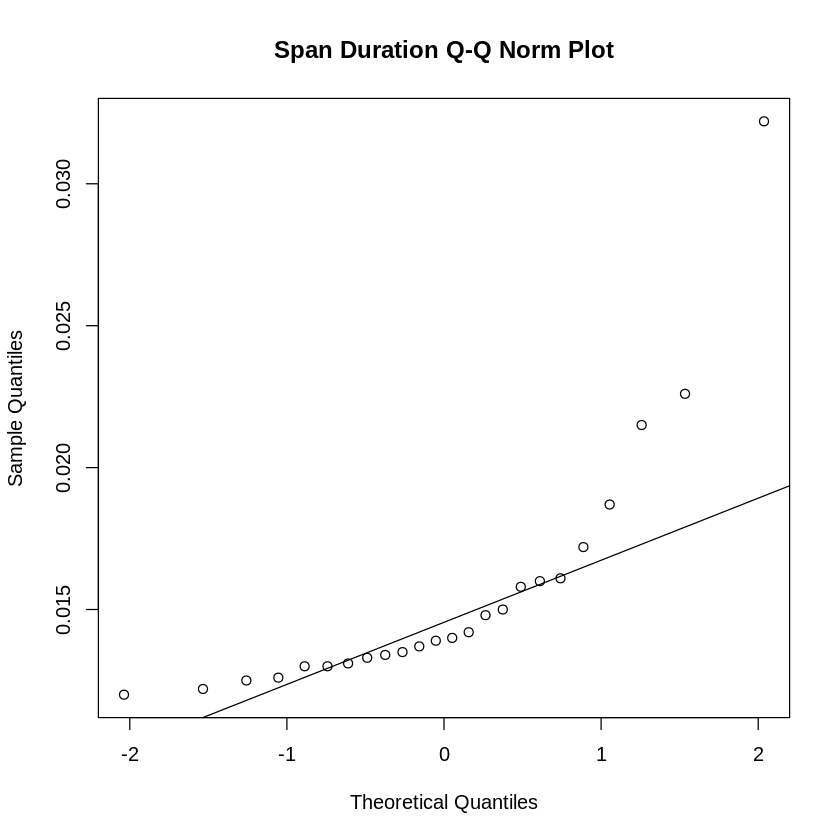

In [11]:
qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(spanMetrics$Duration)

## Autocorrelation ##

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

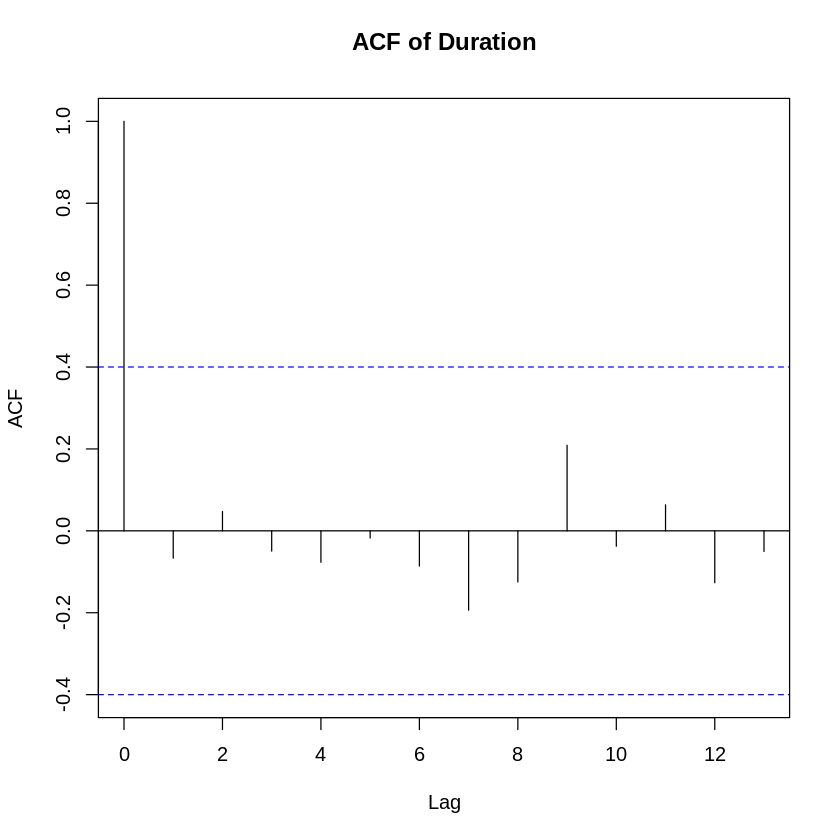

In [12]:
acf(spanMetrics$Duration, main="ACF of Duration")

# Hypothesis Testing # 

Modern DevSecOps architectures can be designed to meet hard-real-time latency (μ) requirements using modern computing environments and computing infrastructure:

H0: μ ≤ tbd ms with jitter within latency bounds  
Ha: μ > tbd ms with jitter exceeding latency bounds  
∝ = 0.05

We will use 500 ms; i.e. tbd will be set to 0.5.



## Shapiro test to establish normality

Null hypothesis: the data are normally distributed  
Alternative hypothesis: the data are not normally distributed

In [13]:
shapiro.test(spanMetrics$Duration)


	Shapiro-Wilk normality test

data:  spanMetrics$Duration
W = 0.69781, p-value = 9.424e-06


**REVIEW** p-value = 0.071 > 0.05; fail to reject the null hypothesis that the data is normally distributed.

## T-Test ##

In [14]:
x = spanMetrics$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -529.8, df = 23, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.01402883        Inf
sample estimates:
 mean of x 
0.01559583 
